# LSTM - AQI

## Import Data

In [161]:
import pandas as pd

In [162]:
df = pd.read_csv("../data/data_imputed.csv")

In [163]:
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])

In [164]:
df = df[['timestamp_local','temp','aqi','co','no2','o3','pm10','pm25','so2']]

In [165]:
df.head()

,timestamp_local,temp,aqi,co,no2,o3,pm10,pm25,so2
0,2022-02-01 00:00:00,12.6,385.0,1339.8,76.0,10.7,491.7,347.67,238.0
1,2022-02-01 01:00:00,11.5,404.0,1437.6,76.0,9.3,508.3,359.33,268.0
2,2022-02-01 02:00:00,11.9,421.0,1535.5,76.0,8.0,525.0,371.00,298.0
3,2022-02-01 03:00:00,12.2,425.0,1659.0,68.3,5.3,529.3,374.00,275.7
4,2022-02-01 04:00:00,11.9,430.0,1782.5,60.7,2.7,533.7,377.00,253.3


In [166]:
data = df[['aqi']]

## Data PreProcessing

In [167]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [168]:
dataset = data
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [169]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [170]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(18217, 2)


In [171]:
reframed.head()

,var1(t-1),var1(t)
1,0.753747,0.794433
2,0.794433,0.830835
3,0.830835,0.839400
4,0.839400,0.850107
5,0.850107,0.858672


In [172]:
reframed.columns

Index(['var1(t-1)', 'var1(t)'], dtype='object')

In [173]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 1) (13140,) (5077, 1, 1) (5077,)


## Model Fitting

### Model 1

In [175]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv2D, ConvLSTM1D
from tensorflow.keras.models import Sequential

In [176]:
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
history = model.fit(train_X, train_y, epochs=50, batch_size=264, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
40/40 - 6s - 148ms/step - loss: 0.0747 - val_loss: 0.0035
Epoch 2/50
40/40 - 1s - 15ms/step - loss: 0.0241 - val_loss: 0.0099
Epoch 3/50
40/40 - 0s - 8ms/step - loss: 0.0121 - val_loss: 0.0132
Epoch 4/50
40/40 - 0s - 8ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 5/50
40/40 - 0s - 10ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 6/50
40/40 - 1s - 16ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 7/50
40/40 - 1s - 18ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 8/50
40/40 - 0s - 11ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 9/50
40/40 - 0s - 9ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 10/50
40/40 - 0s - 9ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 11/50
40/40 - 0s - 10ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 12/50
40/40 - 0s - 9ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 13/50
40/40 - 0s - 8ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 14/50
40/40 - 0s - 8ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 15/50
40/40 - 0s - 10ms/step - loss: 0.0032

In [178]:
import matplotlib.pyplot as plt

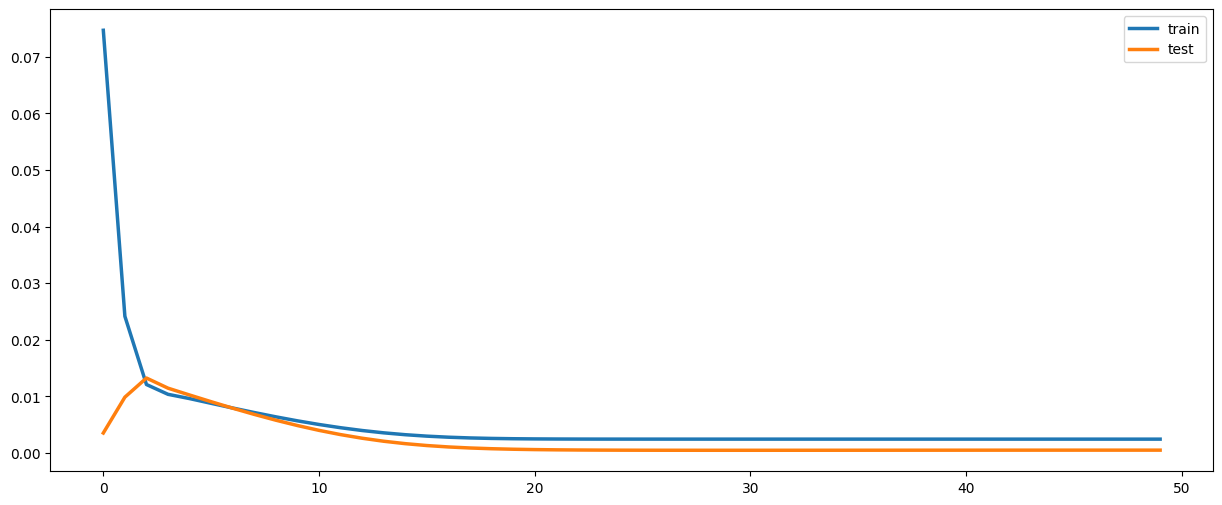

In [179]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [180]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(5077, 1)
(5077,)


In [181]:
y_test_true = test[:,1]

In [182]:
import numpy as np

In [183]:
poll = np.array(df["aqi"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [184]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 175.00923


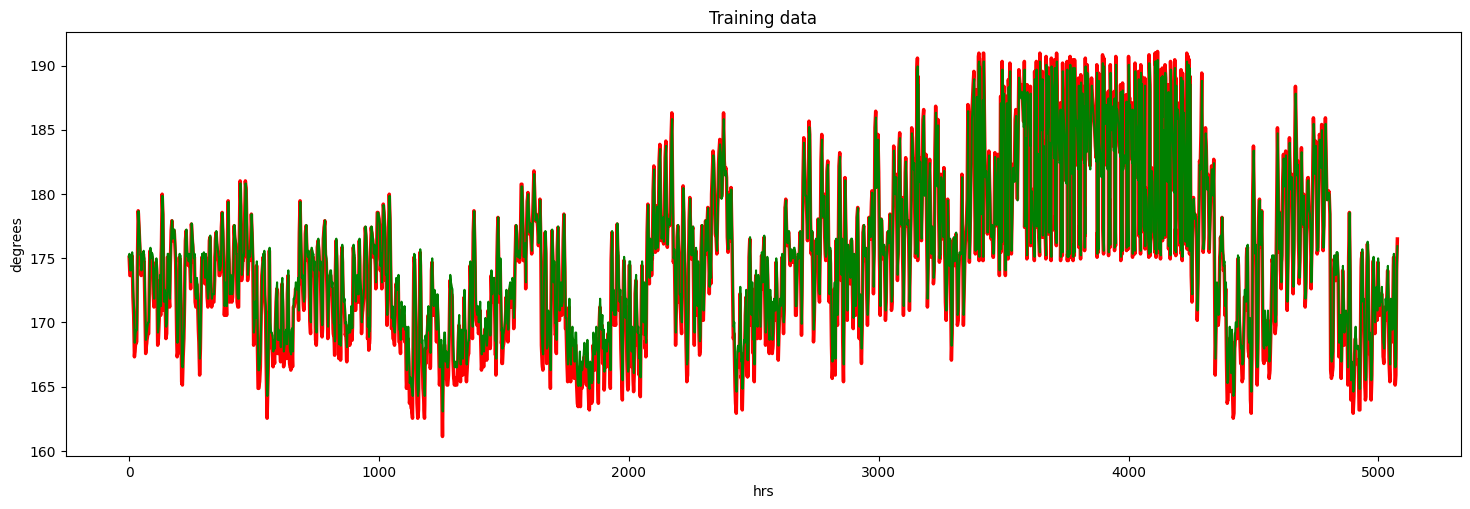

In [185]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict, c = "green")
plt.title("Training data")
plt.show()

### Model 2

In [186]:
model2 = Sequential()
model2.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model2.add(LSTM(256))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,961 (1.07 MB)

 Trainable params: 280,833 (1.07 MB)

 Non-trainable params: 128 (512.00 B)

In [187]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0288 - val_loss: 0.0100
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━

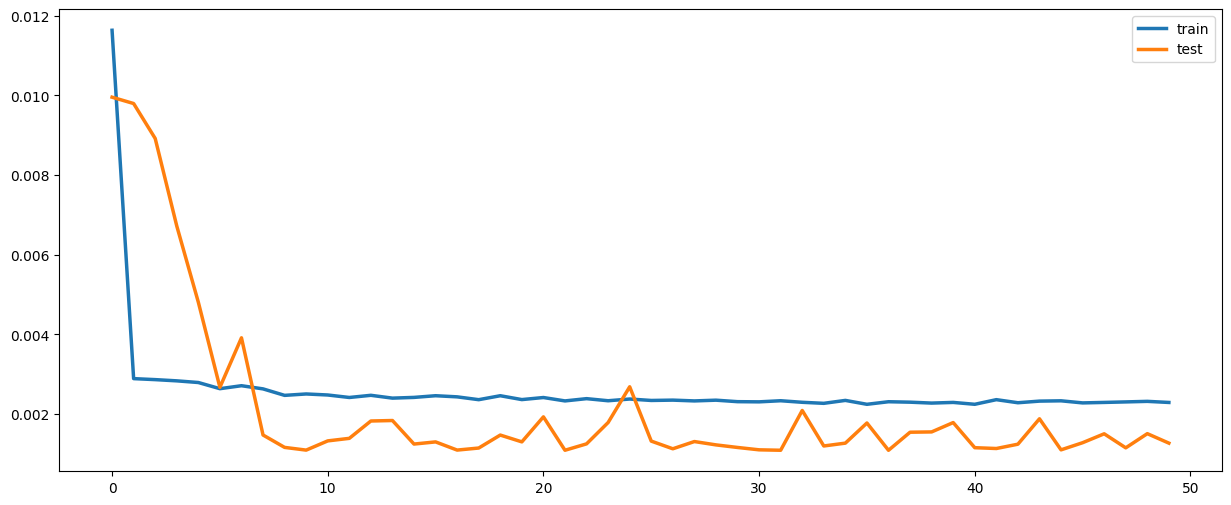

In [188]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [189]:
y_test_true = test[:,1]

In [190]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["aqi"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
159.57388297288395 60.34732650506617


In [191]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.155076


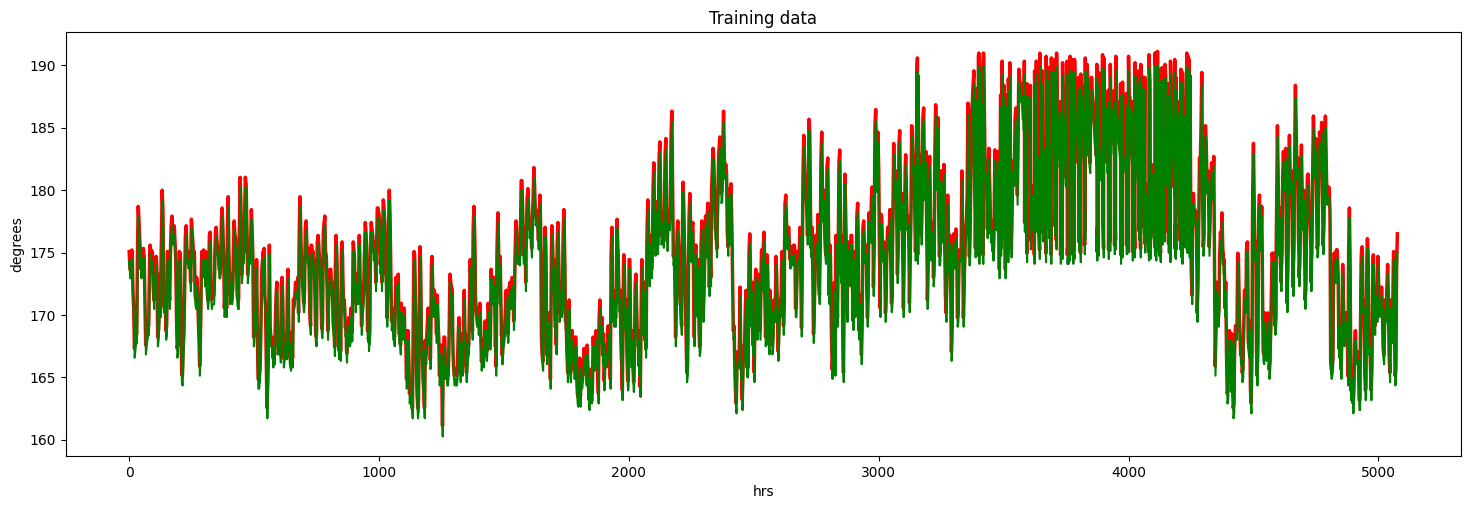

In [192]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict2, c = "green")
plt.title("Training data")
plt.show()

### Model 3

In [193]:
model3 = Sequential()
model3.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model3.add(LSTM(256))
model3.add(Dense(32))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Dense(1))
model3.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,577 (1.04 MB)

 Trainable params: 272,513 (1.04 MB)

 Non-trainable params: 64 (256.00 B)

In [194]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_X, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0637 - val_loss: 0.0181
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038 - val_loss: 0.0209
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033 - val_loss: 0.0209
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - val_loss: 0.0201
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032 - val_loss: 0.0182
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 0.0182
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - val_loss: 0.0170
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - val_loss: 0.0187
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0125
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037 - val_loss: 0.0132
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0128
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

In [195]:
y_test_true = test[:,1]

In [196]:
testPredict3 = model3.predict(test_X)
testPredict3 = testPredict3.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["aqi"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
159.57388297288395 60.34732650506617


In [197]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict3))
print("Training RMSE ="  ,rmse)

Training RMSE = 2.0559025


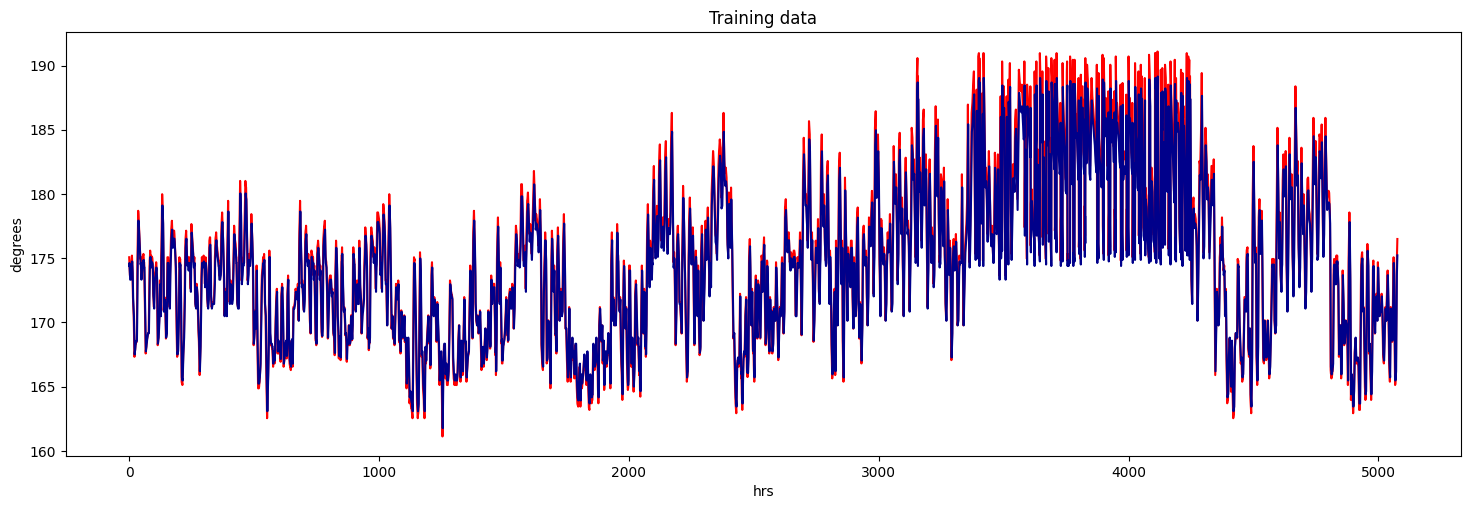

In [198]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red")
plt.plot(testPredict3, c = "darkblue")
plt.title("Training data")
plt.show()

## Forecast

In [39]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[26.380848]
 [26.299622]
 [26.22725 ]
 [26.162817]
 [26.105497]
 [26.054539]
 [26.00926 ]]


In [40]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model2.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[26.589716]
 [26.703257]
 [26.812525]
 [26.917513]
 [27.018232]
 [27.114712]
 [27.207   ]]


In [41]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model3.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[26.40213 ]
 [26.336603]
 [26.275059]
 [26.21723 ]
 [26.162868]
 [26.111746]
 [26.063652]]
